In [1]:
#%%
from LiouvilleLanczos.Quantum_computer.QC_lanczos import Liouvillian_slo,inner_product_slo,sum_slo
from LiouvilleLanczos.Quantum_computer.Hamiltonian import Line_Hubbard,BoundaryCondition
from LiouvilleLanczos.Lanczos import Lanczos
from LiouvilleLanczos.matrix_impl import MatrixState_inner_product,Matrix_Liouvillian,Matrix_sum
from LiouvilleLanczos.Quantum_computer.Mapping import find_best_layout
from LiouvilleLanczos.Green import CF_Green
from qiskit.primitives import StatevectorEstimator as pEstimator

from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import FermionicOp
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit import QuantumCircuit
import numpy as np
from qiskit import transpile
from datetime import datetime
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import matplotlib.pyplot as plt

# Premilinary results
We start by initializing the Hubbard model Hamiltonian for a 2 site Line Lattice, in the second quantization:

$H = \sum_{i,j = 0}^1\sum_{\sigma = \uparrow, \downarrow} t \hspace{1mm} c^{\dag}_{i, \sigma} c_{j, \sigma} + U \sum_{i = 0}^{1} n_{i, \uparrow}n_{i,\downarrow}$

for U = 4, t = -1

In [2]:
U = 4
mapper = JordanWignerMapper()
Ham = Line_Hubbard(-1,U/2,U,2,boundary_condition=BoundaryCondition.OPEN)
#up spin site 1
C2 = FermionicOp(
    {
        "+_2": 1,
    },
    num_spin_orbitals=4,
)
#up spin site 0
C0 = FermionicOp(
    {
        "+_0": 1,
    },
    num_spin_orbitals=4,
)
C0_mat = mapper.map(C0).to_matrix()
C2_mat = mapper.map(C2).to_matrix()
print(Ham)

Fermionic Operator
number spin orbitals=4, number terms=10
  -1 * ( +_0 -_2 )
+ 1 * ( -_0 +_2 )
+ -2.0 * ( +_0 -_0 )
+ -2.0 * ( +_2 -_2 )
+ -1 * ( +_1 -_3 )
+ 1 * ( -_1 +_3 )
+ -2.0 * ( +_1 -_1 )
+ -2.0 * ( +_3 -_3 )
+ 4 * ( +_0 -_0 +_1 -_1 )
+ 4 * ( +_2 -_2 +_3 -_3 )


The algorithm consists of calculating the Green's function by (iteratively) evaluating expectation values of fermionic operators on some state. Here, we are interested in the model at 0 temperature, and thus compute expectation values on the ground state.

The circuit preparing the ground state was found by diagonalizing the hamiltonian analytically. For larger systems, a fully quantum algorithm could use a Hamiltonian simulation algorithm such as VQE to estimate the GS.

-4.82842712474619
-4.8284271246253425


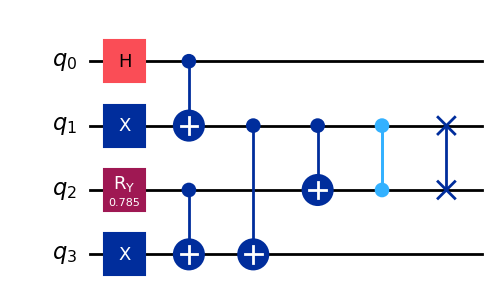

In [3]:
#%% Ground state circuit, obtained by inspection of analytical wavefunction
bt = 0.7854074074074073
GS_analytical = QuantumCircuit(4)
GS_analytical.h(0)
GS_analytical.x(1)
GS_analytical.cx(0,1)
GS_analytical.ry(bt,2)
GS_analytical.x(3)
GS_analytical.cx(2,3)
GS_analytical.cx(1,3)
GS_analytical.cx(1,2)
GS_analytical.cz(1,2)
GS_analytical.swap(1,2)

#%% Sanity check: compare matrix ground energy with simulated estimator ground energy.
Hmat = mapper.map(Ham).to_matrix()
estimator = pEstimator()
qubit_converter = (JordanWignerMapper())
HHam = qubit_converter.map(Ham)
E,S = np.linalg.eigh(Hmat)
GS_mat = S[:,0]
print(E[0])
print(estimator.run([(GS_analytical,HHam)]).result()[0].data.evs)
GS_analytical.draw('mpl')

From the analytic description of the GS, we can calculate the Green's function classically, for reference. Furthermore, perform the LL algorithm on simulator to demonstrate its accuracy.

The operations to be performed on a quantum computer are found in the `polynomial_hybrid` method. The coefficients $\alpha_i$ and $\beta_i$ are found by evaluating expectation values of the form $|\bra{\phi_0} \{f_i, f_j\} \ket{\phi_0}|^2$ where $f_i$ and $f_j$ are fermionic operators and $\ket{\phi_0}$ is the ground state of the Hamiltonian

anomalous termination b at iteration 3
b^2=(1.4667882456453188e-30+0j) is smaller than 1e-13, terminating
anomalous termination b at iteration 3
b^2=6.661338147750939e-16 is smaller than 1e-13, terminating
[(1.0000000000000002+0j), (2.23606797749979+0j), (1.7888543819998317+0j), (3.1304951684997055+0j)]
[0.9999999999999999, 2.23606797749979, 1.7888543819998322, 3.130495168499706]


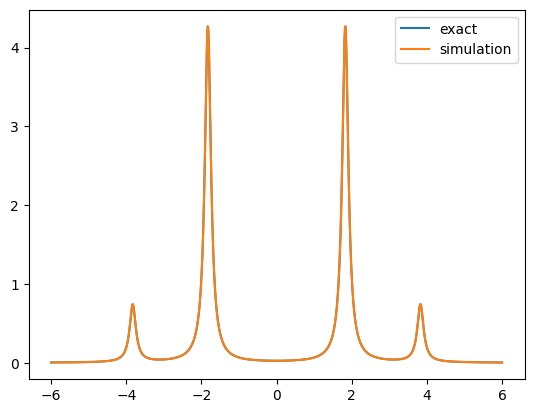

In [4]:
#%% classical computation of the Green's function at site 0
matrix_lanczos = Lanczos(MatrixState_inner_product(GS_mat),Matrix_Liouvillian(),Matrix_sum())
a_ed,b_ed,mu_ed = matrix_lanczos.polynomial_hybrid(Hmat,C0_mat,[C2_mat],10)
green_ed = CF_Green(a_ed,b_ed)

# %% Quantum computer simulation
eps = 1e-6
SQ_inpro = inner_product_slo(GS_analytical,estimator,qubit_converter,eps)
SQ_Liou = Liouvillian_slo(eps)
lanczos = Lanczos(SQ_inpro,SQ_Liou,sum_slo(eps))
a_sim5,b_sim5,mu_sim5 = lanczos.polynomial_hybrid(Ham,C0,[C2],10,5e-3)
green_sim = CF_Green(a_sim5, b_sim5)

print(b_ed)
print(b_sim5)
w = np.linspace(-6,6,1000)
z = w-0.1j
plt.plot(w,np.imag(green_ed(z)),label="exact")
plt.plot(w,np.imag(green_sim(z)),label="simulation")
plt.legend()
plt.show()

# Execution on IBM Quebec

In [13]:
from qiskit_ibm_runtime import (
    Session,
    QiskitRuntimeService,
    EstimatorV2
)
from qiskit_ibm_runtime.options import EstimatorOptions

#<First time only>
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="IBM_TOKEN")
#<\First time only>

service_algolab = QiskitRuntimeService(
    channel="ibm_quantum",
    instance = "pinq-quebec-hub/iq-quantum/algolab"
)

Queb =  service_algolab.backend("ibm_quebec")

backends = {'ibm_quebec':Queb}

class logger:
    def __init__(self):
        self.operator_sizes = []
    def __call__(self,iteration,recursion_operator:SparsePauliOp,a_i,b_i):
        self.operator_sizes.append(len(recursion_operator))
log= logger()
bkd = Queb.name
now = datetime.now()

Since we are using runtime V2 primitives, we use `EstimatorOptions()` to configure error correction and mitigation. In this example, we are using resilience level 1 (readout) as well as $XX$ dynamical decoupling

In [ ]:
with Session(backend=backends[bkd]) as session:

    estim_options = EstimatorOptions()
    backend = backends[session.backend()]
    estim_options.resilience_level = 1
    estim_options.default_shots=10000 #shot noise 10000 -> ~0.01, 100000 -> ~0.003
    estim_options.environment.job_tags = []
    estim_options.dynamical_decoupling.enable = True
    estim_options.dynamical_decoupling.sequence_type = 'XX'
    
    estim = EstimatorV2(backend = backend, session=session,options=estim_options)
    circuit = GS_analytical.copy()
    eps = 1e-5
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    isa_circuit = pm.run(circuit)
    isa_obs = HHam.apply_layout(isa_circuit.layout)
    Ground_state_E_job = estim.run([(isa_circuit, isa_obs)])
    produit_interne = inner_product_slo(isa_circuit, estim, qubit_converter, eps)
    Liou = Liouvillian_slo(eps)
    Summation = sum_slo(eps)
    lanczos = Lanczos(produit_interne,Liou,Summation,logger=log)
    a,b,mu = lanczos.polynomial_hybrid(Ham,C0,[C2],10,5e-2)
    E = Ground_state_E_job.result()[0].data.evs
now = datetime.now()
hour=now.hour
min =now.minute
sec = now.second

# Results

As shown previously, the output of the algorithm is given in the form of a list of coefficients $\alpha$ and $\beta$, which are expectation values of observables. From those coefficients, the Green's function can be calculated. 

Experiments were run on IBM Quebec using varying levels of error correction and mitigation. To evaluate the quality of the results, we inspect the plot of the Green's function, while looking for 3 characteristics:

1. Do the peak locations (in frequency space) match the analytical solution?
2. Is the function symmetric around $\omega = 0$
3. Are there any parasitic peaks where there should not be any?

Results are shown below for 
1. Readout mitigation only
2. Readout + DD
3. Readout + ZNE + Twirling (resilience 2)
4. Readout + ZNE + Twirling + DD 

An obvious indicator of performance is by looking at the values for the $\alpha$. Indeed, they are all zero in the analytical solution, and thus any deviation from zero is error.

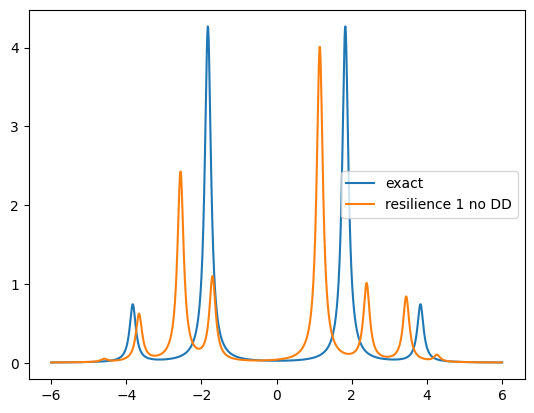

In [5]:
#resilience 1, no DD
a_res_1 = [(-0.01918208), (-0.33629506), (0.95828326), (-1.45513689), (1.11596598), (-1.21770211), (0.52064179), (-0.75203269), (0.36388316), (-0.79754124)]
b_res_1 = [1.0, 2.234590208418395, 1.8173699387907898, 2.4171502456927954, 1.854759714551501, 2.8640791623486317, 2.5946627385585193, 4.196457525409674, 3.578447775691862, 4.2419749281517705]
green_res_1 = CF_Green(a_res_1, b_res_1)

plt.plot(w,np.imag(green_ed(z)),label="exact")
plt.plot(w,np.imag(green_res_1(z)),label="resilience 1 no DD")
plt.legend()

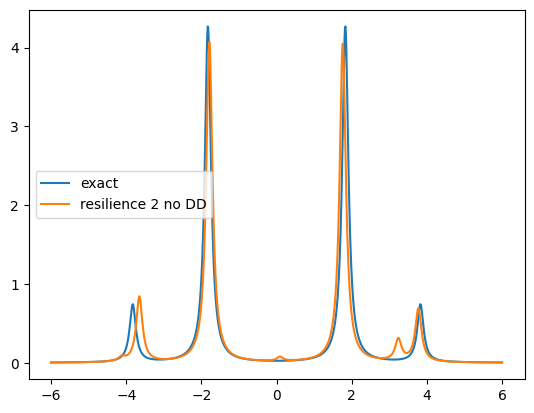

In [6]:
#resilience 2, no DD
a_res_2 = [(-3.83619290977089e-05+0j), (0.000566247586374042-7.415517638723499e-08j), (0.022703384112746933+5.175510575536806e-07j), (-0.04249663679738006-2.302211807074641e-05j), (0.3235110430862287+0.0007281341540251784j), (-1.0191743616252436+0.0023723395856046787j), (0.013822086993335425-0.006873279220722696j)]
b_res_2 =[(0.9999999999999997+0j), (2.2360679761593665+0j), (1.7888548707619536+0j), (2.934078339828888+0j), (0.5318792409847123+0j), (3.120589991379859+0j), (1.811165290280878+0j)]
green_res_2 =  CF_Green(a_res_2, b_res_2)


plt.plot(w,np.imag(green_ed(z)),label="exact")
plt.plot(w,np.imag(green_res_2(z)),label="resilience 2 no DD")
plt.legend()

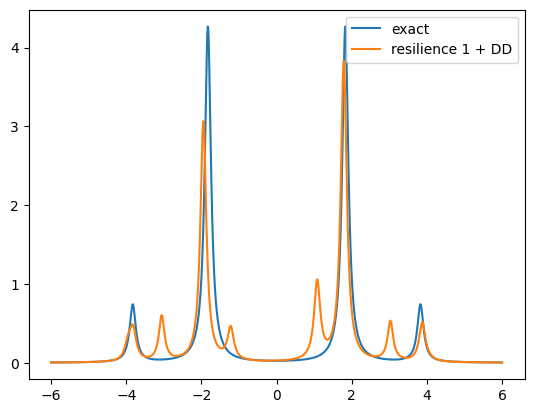

In [7]:
#resilience 1, with XX DD
a_res_1_DD = [(0.09271128926636638+0j), (-0.31698532540512103-0.003572352402397284j), (0.3933722857171073+0.01524312739576108j), (-0.35909771202053486-0.018803127527701264j), (0.4015336586638849+0.002393488087792875j), (-0.450666440361444-0.02716183433318591j), (0.42077387142958994-0.01639072954264988j), (-0.5582855047097648+0.01126677989657012j), (0.7472543479313848+0.0331584135127503j), (-0.48566813242169493-0.003928619712815829j)]
b_res_1_DD = [(1+0j), (2.2366377695204447+0j), (1.8018416380255118+0j), (2.88665503100614+0j), (1.1549048149380159+0j), (2.3727221045560603+0j), (1.752944543077286+0j), (1.6960178260076464+0j), (1.6340630064406159+0j), (3.4686318608901883+0j)]
green_res_1_DD =  CF_Green(a_res_1_DD, b_res_1_DD)

plt.plot(w,np.imag(green_ed(z)),label="exact")
plt.plot(w,np.imag(green_res_1_DD(z)),label="resilience 1 + DD")
plt.legend()

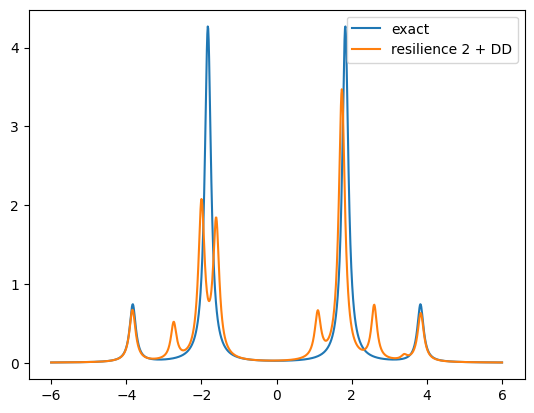

In [8]:
#resilience 2 with XX DD
a_res_2_DD = [(0.027579791901685226+0j), (-0.1033434231337379-2.429252505082466e-18j), (0.1649718542295569+0.002474221419690498j), (-0.21725276607681038-0.0023182012054700912j), (0.4174805005747976+0.00036818708430134863j), (-0.42838739173077545-0.016793013573270742j), (0.5161839504966862-0.0035517159180880687j), (-1.1751701733915476+0.03859305326928984j), (0.22061274039954604-0.015241361609593112j), (-1.2260605782873066-0.036203119120510864j)]
b_res_2_DD = [(0.9999999999999997+0j), (2.234748735700201+0j), (1.791667179067065+0j), (2.9508878155678078+0j), (1.0040204017863552+0j), (2.2276798321250815+0j), (1.2049615234203745+0j), (1.9583696983695051+0j), (2.036104416462324+0j), (2.836690416397969+0j)]
green_res_2_DD =  CF_Green(a_res_2_DD, b_res_2_DD)

plt.plot(w,np.imag(green_ed(z)),label="exact")
plt.plot(w,np.imag(green_res_2_DD(z)),label="resilience 2 + DD")
plt.legend()

# Transpilation test

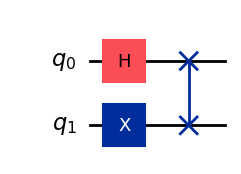

In [9]:
qc_test = QuantumCircuit(2)
qc_test.h(0)
qc_test.x(1)
qc_test.swap(0,1)
qc_test.draw('mpl')


In [10]:
estim = pEstimator()
obs = SparsePauliOp.from_list([('XZ',1)],)
res = estim.run([(qc_test, obs)])
res.result()[0].data.evs

array(-1.)

SparsePauliOp(['IIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXII'],
              coeffs=[1.+0.j])


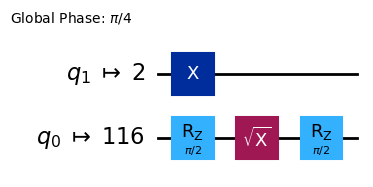

In [15]:
Queb =  service_algolab.backend("ibm_quebec")
pass_manager = generate_preset_pass_manager(backend=Queb, optimization_level=3)
isa_circuit = pass_manager.run(qc_test)
isa_obs = obs.apply_layout(isa_circuit.layout)
print(isa_obs)
isa_circuit.draw('mpl', idle_wires=False)

In [16]:
with Session(backend=Queb) as session:
        estim = EstimatorV2(backend = Queb, session=session)
        res_qc = estim.run([(isa_circuit, isa_obs)])

In [17]:
res_qc.result()[0].data.evs

array(-0.00099701)

In [ ]:
isa_circuit.layout